In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oyebamijimicheal/fitzpatrick-black-skin-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fitzpatrick-black-skin-disease-dataset


In [2]:
import os

fitz_dir = '/kaggle/input/fitzpatrick-black-skin-disease-dataset/fitzpatrick-black-images'  # replace with the actual path
classes = os.listdir(fitz_dir)
classes.sort()

print("Total Classes:", len(classes))
for i, c in enumerate(classes):
    print(f"{i+1}. {c}")


Total Classes: 114
1. acanthosis_nigricans
2. acne
3. acne_vulgaris
4. acquired_autoimmune_bullous_diseaseherpes_gestationis
5. acrodermatitis_enteropathica
6. actinic_keratosis
7. allergic_contact_dermatitis
8. aplasia_cutis
9. basal_cell_carcinoma
10. basal_cell_carcinoma_morpheiform
11. becker_nevus
12. behcets_disease
13. calcinosis_cutis
14. cheilitis
15. congenital_nevus
16. dariers_disease
17. dermatofibroma
18. dermatomyositis
19. disseminated_actinic_porokeratosis
20. drug_eruption
21. drug_induced_pigmentary_changes
22. dyshidrotic_eczema
23. eczema
24. ehlers_danlos_syndrome
25. epidermal_nevus
26. epidermolysis_bullosa
27. erythema_annulare_centrifigum
28. erythema_elevatum_diutinum
29. erythema_multiforme
30. erythema_nodosum
31. factitial_dermatitis
32. fixed_eruptions
33. folliculitis
34. fordyce_spots
35. granuloma_annulare
36. granuloma_pyogenic
37. hailey_hailey_disease
38. halo_nevus
39. hidradenitis
40. ichthyosis_vulgaris
41. incontinentia_pigmenti
42. juvenile_xan

In [3]:
import os
import shutil

# Source and destination
source_dir = '/kaggle/input/fitzpatrick-black-skin-disease-dataset/fitzpatrick-black-images'
target_dir = '/kaggle/working/skin_data'

# Chosen cosmetic classes
cosmetic_classes = [
    'acne', 'acne_vulgaris', 'rosacea',
    'folliculitis', 'keratosis_pilaris', 'seborrheic_dermatitis'
]

# Copy only selected classes
os.makedirs(target_dir, exist_ok=True)

for cls in cosmetic_classes:
    src_path = os.path.join(source_dir, cls)
    dest_path = os.path.join(target_dir, cls)
    if os.path.exists(src_path):
        shutil.copytree(src_path, dest_path)
        print(f"✔ Copied {cls}")
    else:
        print(f"❌ Skipped {cls} (not found)")


✔ Copied acne
✔ Copied acne_vulgaris
✔ Copied rosacea
✔ Copied folliculitis
✔ Copied keratosis_pilaris
✔ Copied seborrheic_dermatitis


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Directories
data_dir = '/kaggle/working/skin_data'

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Check number of classes
print("Class indices:", train_generator.class_indices)


Found 392 images belonging to 6 classes.
Found 95 images belonging to 6 classes.
Class indices: {'acne': 0, 'acne_vulgaris': 1, 'folliculitis': 2, 'keratosis_pilaris': 3, 'rosacea': 4, 'seborrheic_dermatitis': 5}


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # Freeze base model

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)  # 6 classes

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


<ipython-input-5-4d714947477c>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Unfreeze the last few layers of MobileNetV2
fine_tune_at = 100  # unfreeze from this layer onward
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train again (fine-tune)
fine_tune_epochs = 30

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs
)



Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4494 - loss: 1.5423 - val_accuracy: 0.5789 - val_loss: 1.1393
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.4681 - loss: 1.4113 - val_accuracy: 0.6105 - val_loss: 1.0177
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.5130 - loss: 1.3714 - val_accuracy: 0.6526 - val_loss: 1.0729
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.4722 - loss: 1.3983 - val_accuracy: 0.5474 - val_loss: 1.1445
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.4947 - loss: 1.2607 - val_accuracy: 0.6316 - val_loss: 1.0690
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.4634 - loss: 1.3910 - val_accuracy: 0.5895 - val_loss: 1.1383
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.5799 - loss: 1.1306 - val_accuracy: 0.5368 - val_loss: 1.1650
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.5288 - loss: 1.2762 - val_accuracy: 0.57

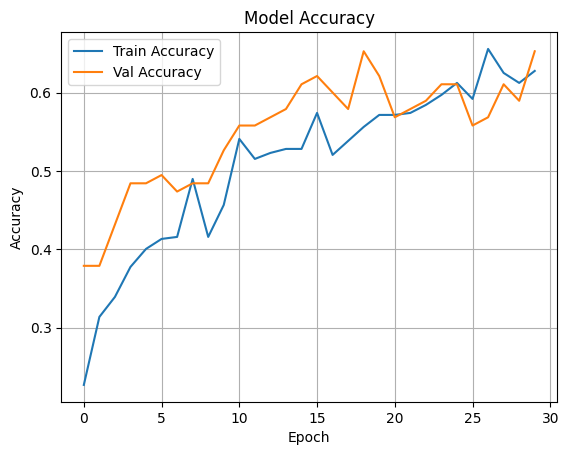

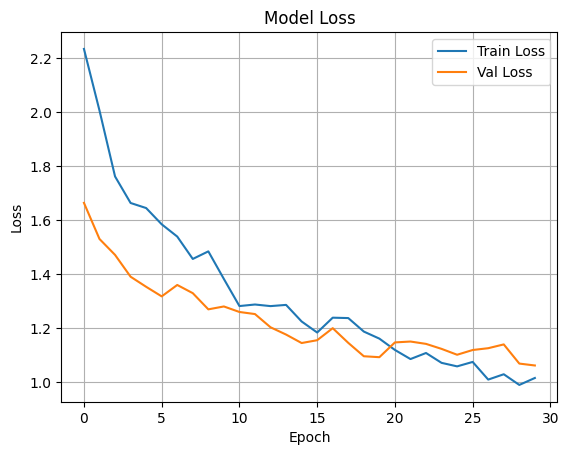

In [13]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


<Figure size 800x600 with 0 Axes>

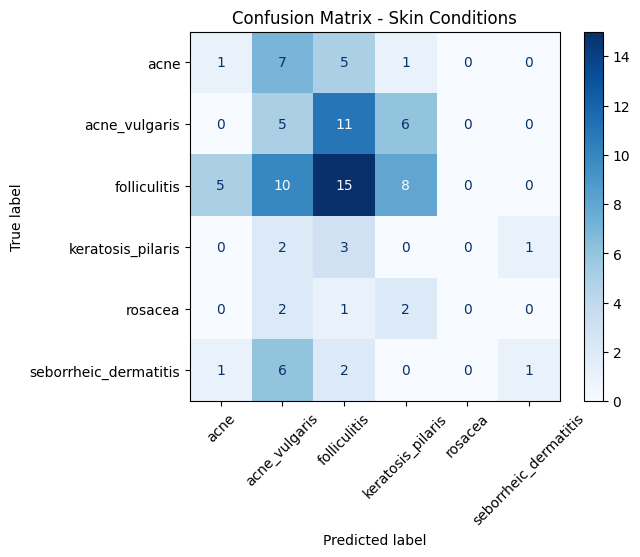

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get true labels and predicted labels
val_generator.reset()  # important to match the batch order
Y_true = val_generator.classes
Y_pred_probs = model.predict(val_generator)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Skin Conditions")
plt.grid(False)
plt.show()


In [16]:
model.save('/kaggle/working/skin_analyzer_model.h5')